# Heavy traffic indicators for Interstate 94

`Category: Exploratory Data Analysis`

Interstate 94 (I-94) is an east–west Interstate Highway connecting the Great Lakes and northern Great Plains regions of the United States (from [Wikipedia](https://en.wikipedia.org/wiki/Interstate_94)). 

In this project, we're going to analyse a dataset of hourly traffic volume data, including weather conditions. The data are referred to the portion of I-94 between Minneapolis and St. Paul, Minnesota. They were recorded by a station roughly midway between the two cities, and for the traffic directed from Saint Paul to Minneapolis. Any conclusion is therefore valid at most for this part of I-94 and for the traffic moving westward.

The original dataset can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume), the repository for Machine Learning at UCI.

The main goal of the project is trying to **find indicators of heavy traffic on I-94**, i.e. conditions which correlate more or less explicitly with heavy traffic.

In [1]:
import pandas as pd

In [2]:
## reading the dataset and displaying general info ##

df = pd.read_csv('datasets/Metro_Interstate_Traffic_Volume.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The dataset is made of 48204 data points with 9 pieces of info each, and apparently it doesn't have missing values although object (i.e. string) type could have missing values coded in some form.

Here's a preview of the data:

In [24]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


The column `temp` is the recorded temperature in K. `rain_1h` and `snow_1h` record the quantinty of fallen rain and snow, in mm. `clouds_all` records the percentage of sky covered by clouds. `traffic_volume` is the metric for the traffic conditions, in vehicles/hour.

The data were recorded from October 2, 2012 to September 30, 2018:

In [3]:
print(df['date_time'].min())
print(df['date_time'].max())

2012-10-02 09:00:00
2018-09-30 23:00:00


## Distribution of traffic volume

We start the analysis by plotting a histogram of the main column, `traffic_volume`:

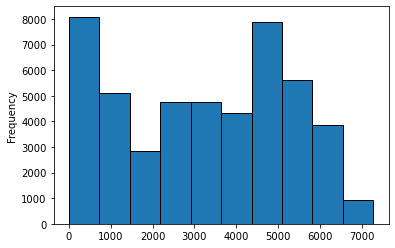

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

df['traffic_volume'].plot.hist(ec='black')
plt.show()

In [5]:
df['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

From the summary statistics, we understand that 50% of the time the traffic volume is under 4000 vehicles per hour. From the histogram, the most recurrent traffic volume is in the (approximate) intervals 0-700 and 4300-5000 vehicles per hour. These two peaks may be an indication of two different traffic patterns; probably the firts peak (low traffic) occur during the night and/or weekends, the second (heavy traffic) during business days and daytime.

The distribution doesn't seem to follow any known pattern. Considering the previous observations, we're going to divide the dataset in two parts:

* **daytime**: from 7 am to 7 pm
* **nighttime**: from 7 pm to 7 am

## Daytime vs. nighttime traffic

Before we start the comparison, we first need to convert the `date_time` column from string to datetime type.

In [6]:
df['date_time'] = pd.to_datetime(df['date_time'])

We can now divide the original dataset in two sub-datasets:

In [7]:
daytime = df[(df['date_time'].dt.hour >= 7)  & (df['date_time'].dt.hour < 19)]
nighttime = df[df['date_time'].dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6])]

To better understand the influence of day and night on traffic volume, we plot the histograms for traffic volume in a grid chart:

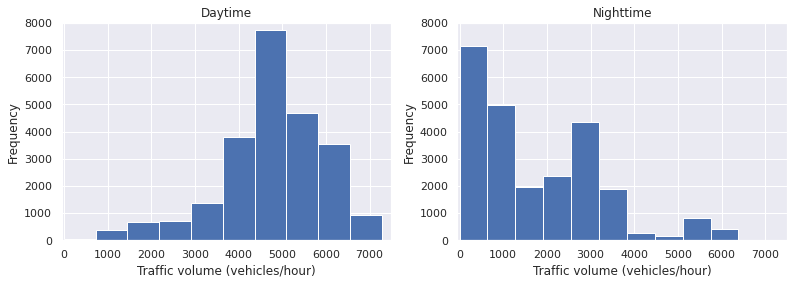

In [28]:
f = plt.figure(figsize=(13,4))
# f.suptitle('Traffic volume (vehicles/hour)')

# daytime chart
plt.subplot(1,2,1)
daytime['traffic_volume'].plot.hist(ec='white')
plt.title('Daytime')
plt.xlabel('Traffic volume (vehicles/hour)')
plt.xlim([-50,7500])
plt.ylim([0,8000])

# nighttime chart
plt.subplot(1,2,2)
nighttime['traffic_volume'].plot.hist(ec='white')
plt.title('Nighttime')
plt.xlabel('Traffic volume (vehicles/hour)')
plt.xlim([-50,7500])
plt.ylim([0,8000])

plt.show()

*(Notice that the y axis and x axis ranges are the same in the two graphs, so they're directly comparable.)*

The two distributions are not symmetric: the daytime histogram is left-skewed, the nighttime histogram is right-skewed. This means that there's a tendency towards heavy traffic during the day, and a lighter traffic volume during the night. Qualitatively, the nighttime histogram has an exponentially-decreasing behavior, except for the 'spike' at about 2600-3100 vehic/hour. This means that the body of the distribution is in the lower traffic region. 

Let's also consider the following two summary statistics for the same data:

In [9]:
daytime['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [10]:
nighttime['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

From the summary statistics above, we see a mean of 4762 vehic./hour during the day and 1785 during the night, a sign of much lighter traffic. Furthermore, during the night 75% of the time the traffic is under 2800 vehic./hour, while during the day 75% of the time it is above 4200 vehic./hour. As we noted from the corresponding graph, the bulk of the nighttime distribution is in the lower traffic region: 50% of the data are under 1300 vehic./hour. 

The two situations are therefore much different, as we already conjectured. We're searching for indicators of heavy traffic, so we'll focus on daytime data as they seem more strongly correlated with heavy traffic.

## Time indicators (monthly, daily, hourly)

Let's start by plotting the average traffic volume for each month.

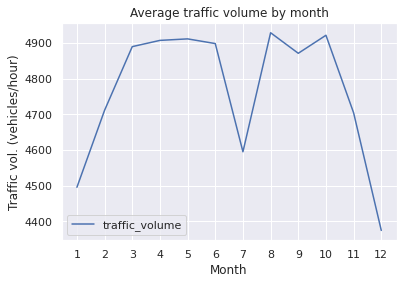

In [29]:
# grouping the data by month and calculating the average
monthly_avg_traffic = daytime[['date_time', 'traffic_volume']].groupby(daytime['date_time'].dt.month).mean()

# plotting the data
monthly_avg_traffic.plot.line()
plt.title('Average traffic volume by month')
plt.xlabel('Month')
plt.ylabel('Traffic vol. (vehicles/hour)')
plt.xticks(range(1,13))
# plt.ylim([0,5000])

plt.show()

The monthly traffic volume does not vary in a significant way: the fluctuations are O(5%) with respect to the average of ~ 4700 vehicles/hour (notice that the y axis does not start at zero).

We'll now consider daily averages.

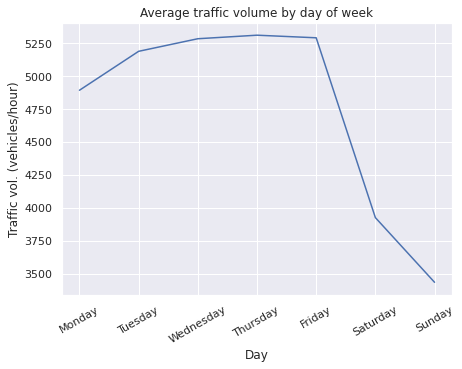

In [30]:
# extracting weekday (from 0 to 6)
weekdays = daytime['date_time'].dt.day_name()

# calculating the average traffic for each day of the week
daily_avg_traffic = daytime.groupby(weekdays).mean()['traffic_volume']
# order the days in the standard way 
daily_avg_traffic = daily_avg_traffic.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

# plotting the data
plt.figure(figsize=(7,5))
daily_avg_traffic.plot.line()
plt.xticks(rotation=30)
plt.title('Average traffic volume by day of week')
plt.xlabel('Day')
plt.ylabel('Traffic vol. (vehicles/hour)')
# plt.ylim([0,5400])

plt.show()

We notice immediately that the traffic volume stays between 4900 and 5300 vehicles/hour over business days (mon-fri). It drops significantly over the weekend (sat-sun) with less than 4000 vehicles.

This behavior is easily explainable considering that workers move between the two cities during business days. Let's see if this is confirmed by looking at average hourly traffic.

In [13]:
# separating business and weekend days
business = daytime[daytime['date_time'].dt.weekday <= 4]  # 4 == Friday
weekend = daytime[daytime['date_time'].dt.weekday >= 5]  # 5 == Saturday

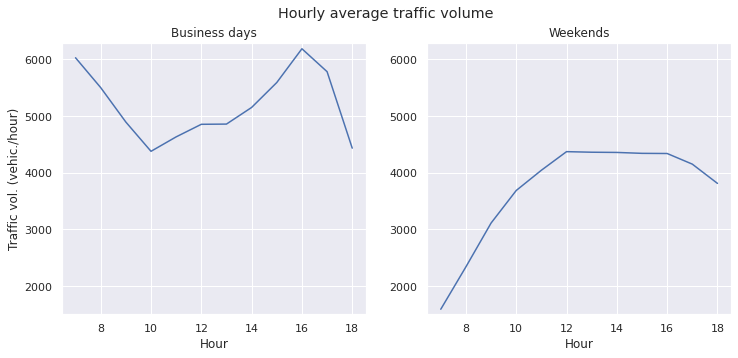

In [31]:
# extracting the hours from the date_time column
hours_business = business['date_time'].dt.hour
hours_weekend = weekend['date_time'].dt.hour

# calculating average traffic volume each hour, for business and weekend days
hourly_avg_traffic_business = business.groupby(hours_business).mean()['traffic_volume']
hourly_avg_traffic_weekend = weekend.groupby(hours_weekend).mean()['traffic_volume']

# plotting the data
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(12,5))
fig.suptitle('Hourly average traffic volume')

plt.subplot(1,2,1)
hourly_avg_traffic_business.plot.line()
plt.ylim([1500, 6300])
plt.xlabel('Hour')
plt.ylabel('Traffic vol. (vehic./hour)')
plt.title('Business days')

plt.subplot(1,2,2)
hourly_avg_traffic_weekend.plot.line()
plt.ylim([1500, 6300])
plt.xlabel('Hour')
plt.title('Weekends')

plt.show()

As we already saw in the previous chart, during business days the traffic volume is much higher than on weekends. In fact, this is confirmed by these grid charts: during business days, we observe intense traffic from 7 to 9 and from 15 to 17, with more than 5000 vehicles per hour. This traffic is mainly generated by workers going to work early in the morning and going back home in the afternoon. 

During weekends, the most intense traffic is from 12 to 18, but it's always smaller than on working days.


## Weather indicators

To investigate weather indicators, we'll focus on business days because of their heavier traffic.

### - Numerical columns

Let's evaluate the correlation between traffic volume and numerical weather columns (`temp`, `rain_1h`, `snow_1h`, `clouds_all`) during business days.

In [15]:
business.corr()['traffic_volume'][:-1]

temp          0.139999
rain_1h       0.002728
snow_1h      -0.008016
clouds_all   -0.081708
Name: traffic_volume, dtype: float64

The highest correlation is with **temperature**: Pearson's r is **0.14**, although the value is much closer to 0 than close to 1. We'll draw a scatter plot to invesitgate further this correlation. 

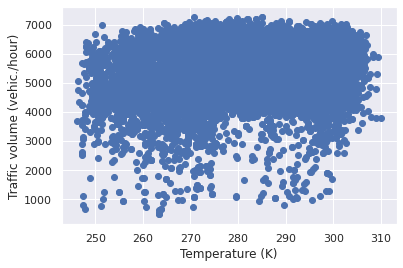

In [16]:
plt.scatter(x=business['temp'], y=business['traffic_volume'])
plt.xlabel('Temperature (K)')
plt.ylabel('Traffic volume (vehic./hour)')
plt.show()
# plt.scatter(x=daytime['rain_1h'], y=daytime['traffic_volume'])
# plt.show()
# plt.scatter(x=daytime['snow_1h'], y=daytime['traffic_volume'])
# plt.show()
# plt.scatter(x=daytime['clouds_all'], y=daytime['traffic_volume'])
# plt.show()

Visually, we don't notice any reasonable correlation between temperature and traffic. The data are all scattered around, while we expect to see them arranged in a linear pattern for strongly correlated variables.

The same can be said for the other columns (uncomment the code in the previous cell to verify it).
Therefore we can conclude there's no reliable indicator of heavy traffic among the numerical weather columns.

### - Categorical columns

Let's now consider the categorical weather columns, `weather_main` and `weather_description`.

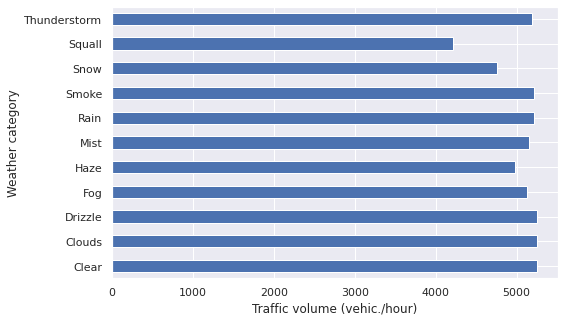

In [32]:
# grouping by weather type in weather_main and calculating the average traffic volume
weather_main_avg_traffic = business.groupby(['weather_main']).mean()['traffic_volume']

# plotting the data
plt.figure(figsize=(8,5))
weather_main_avg_traffic.plot.barh()
plt.ylabel('Weather category')
plt.xlabel('Traffic volume (vehic./hour)')

plt.show()

Our analysis of the daily and hourly average traffic volume highlithted that intense traffic on working days is characterised by 5000 vehicles per hour or more. From the previous chart we observe that weather conditions with reduced visibility (rain, smoke, mist etc) seem to correlate with heavy traffic. Nonetheless, we also observe that clear sky also has more than 5000 v. per hour. Therefore we cannot draw any definitive conclusion.

Let's look at the average traffic for the `weather_description` column which has a more granular structure:

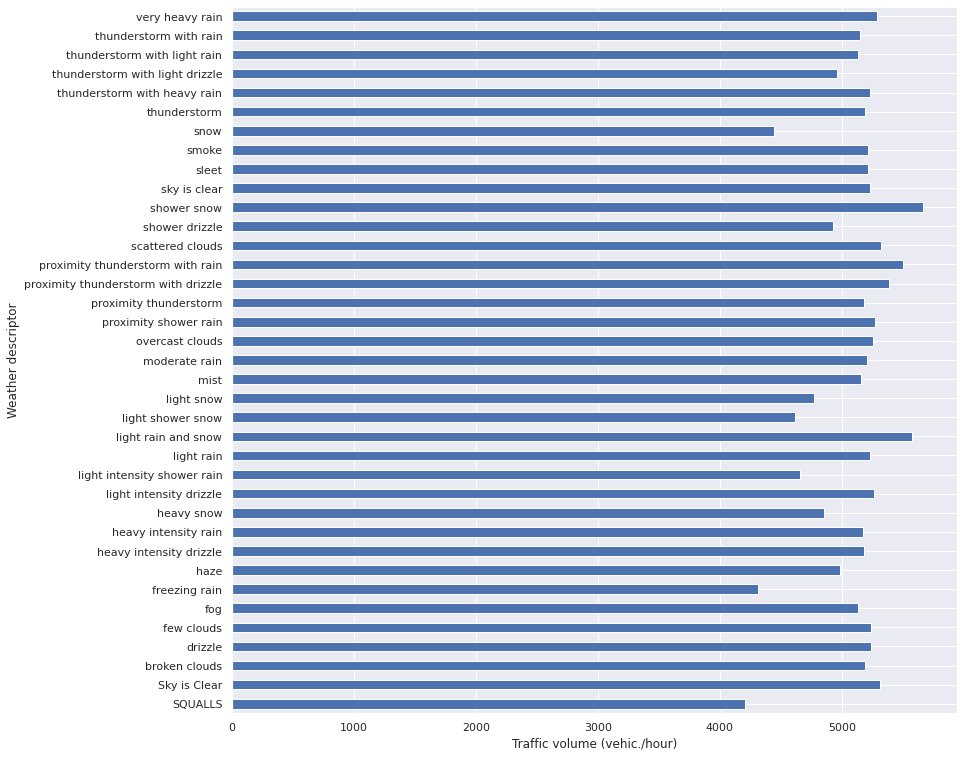

In [33]:
weather_main_avg_traffic = business.groupby(['weather_description']).mean()['traffic_volume']

plt.figure(figsize=(13,13))
weather_main_avg_traffic.plot.barh()
plt.ylabel('Weather descriptor')
plt.xlabel('Traffic volume (vehic./hour)')

plt.show()

As in the first chart, we observe contradictory evidence because both bad weather conditions and clear sky are characterised by more than 5000 vehicles per hour. Again, we cannot draw any definitive conlusion for heavy traffic indicators.

## Conclusion

In this project, we've tried to find some indicators of heavy traffic for I-94 between Minneapolis and Saint Paul, moving westward.
The results can be summarised as follow:

* Traffic volumes are heavier on business days than weekends, and rush hours are around 7-8 am and 3-5 pm.
* There's no relevant dependency from the month, with fluctuations of the order of 5% in traffic volume.
* No reliable weather indicators have been found.
